In [1]:
!pip install torch torchvision matplotlib scikit-learn seaborn


In [2]:
# handwritten_recognition.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Data Preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]


In [3]:
# -------------------------
# 2. CNN Model
# -------------------------
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
# 3. Training
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")


Epoch 1/5 - Loss: 0.0028
Epoch 2/5 - Loss: 0.0032
Epoch 3/5 - Loss: 0.0176
Epoch 4/5 - Loss: 0.0302
Epoch 5/5 - Loss: 0.0009


Test Accuracy: 98.95%


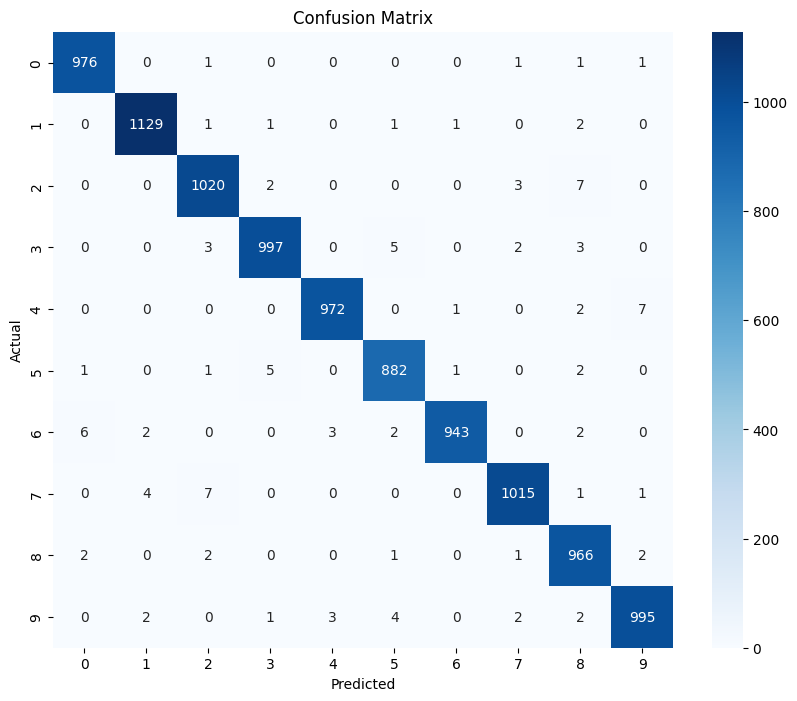

In [5]:
# 4. Evaluation
# -------------------------
model.eval()
preds, labels = [], []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

acc = accuracy_score(labels, preds)
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


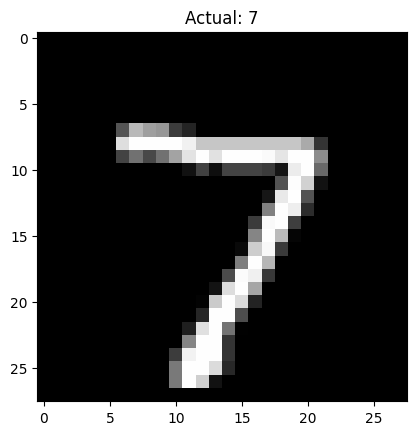

Predicted: 7


In [6]:

# 5. Demo Prediction
# -------------------------
def demo_prediction(index):
    img, label = test_dataset[index]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}")
    plt.show()

    model.eval()
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
        print(f"Predicted: {pred}")

# Example demo
demo_prediction(0)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, img_channels=1, num_classes=36, hidden_size=128, num_layers=2):
        super(CRNN, self).__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(img_channels, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # RNN for sequence modeling
        self.rnn = nn.LSTM(input_size=128*7, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size*2, num_classes)  # bidirectional => hidden_size*2

    def forward(self, x):
        # x shape: (batch, channels, height, width)
        features = self.cnn(x)  # (batch, channels, H, W)
        b, c, h, w = features.size()
        features = features.permute(0,3,1,2)  # (batch, width, channels, height)
        features = features.reshape(b, w, c*h) # sequence length = width
        rnn_out, _ = self.rnn(features)
        output = self.fc(rnn_out)  # (batch, seq_len, num_classes)
        return output
